In [172]:
import env
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import utilities as utils

from acquire_sasebo import acquire_sasebo_df
from prepare_sasebo import prepare_sasebo_df
from sklearn.metrics import mean_squared_error
from math import sqrt 
from statsmodels.tsa.api import Holt

## Acquire and Prep

In [3]:
sasebo_df = prepare_sasebo_df(acquire_sasebo_df())

array([[<AxesSubplot:title={'center':'avg_temp'}>]], dtype=object)

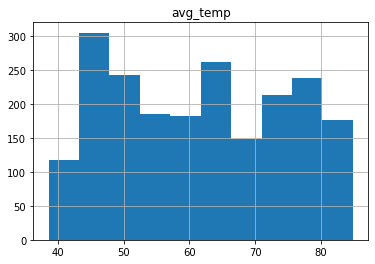

In [7]:
sasebo_df.hist()

## Splitting the dateframe

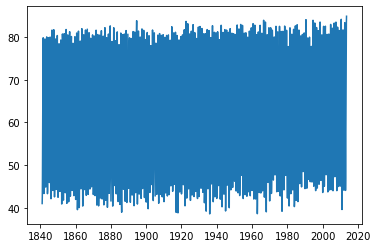

In [10]:
plt.plot(sasebo_df.index, sasebo_df.avg_temp)

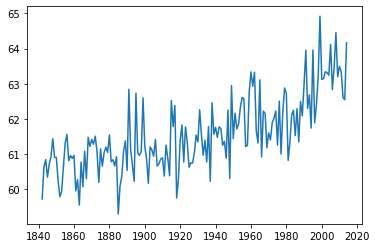

In [11]:
yearly_avg = sasebo_df.resample('A').mean()
plt.plot(yearly_avg)

In [40]:
year_1986 = sasebo_df[sasebo_df.index.year == 1986]

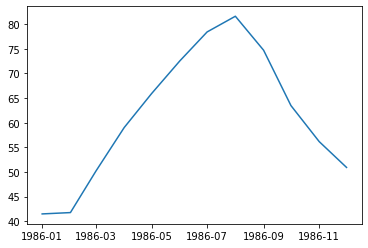

In [42]:
plt.plot(year_1986.index, year_1986.avg_temp)

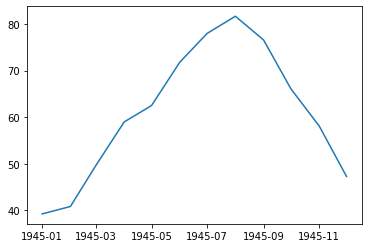

In [43]:
year_1945 = sasebo_df[sasebo_df.index.year == 1945]
plt.plot(year_1945.index, year_1945.avg_temp)

There seems to be a season each year, but I will use percentages to estimate what years I should split my dataframe on.

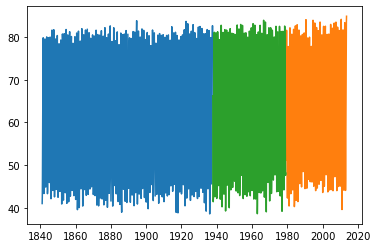

In [47]:
# 80/20 train/test split
train_size = .80
n = sasebo_df.shape[0]
test_start_index = round(train_size * n)

train = sasebo_df[:test_start_index]
test = sasebo_df[test_start_index:]

validate_size = .30
train_length = train.shape[0]
# Need to do (1 - validate_size) otherwise the size of validate will actually be 70% of train.
validate_start_index = round((1 - validate_size) * train_length)

train = sasebo_df[:validate_start_index]
validate = sasebo_df[validate_start_index : test_start_index]

plt.plot(train.index, train.avg_temp)
plt.plot(test.index, test.avg_temp)
plt.plot(validate.index, validate.avg_temp)
plt.show()

In [48]:
train.shape, validate.shape, test.shape

((1161, 4), (497, 4), (414, 4))

The divisions appear to be around 1940 and 1980, so I will split my dataframe on those years.

In [70]:
train_2 = sasebo_df[:'1940']
validate_2 = sasebo_df['1940' : '1980']

In [57]:
train = sasebo_df[:'1939']
validate = sasebo_df['1940' : '1979']
test = sasebo_df['1980':]

In [59]:
train.shape, validate.shape, test.shape

((1188, 4), (480, 4), (404, 4))

In [60]:
sasebo_df.shape[0] == train.shape[0] + validate.shape[0] + test.shape[0]

True

I verified that the sum of the train, validate, test lengths are equal to that of the original df.

## Exploration

In [61]:
y = train.avg_temp
y.head()

dt
1841-01-01    41.0054
1841-02-01    42.6254
1841-03-01    46.8338
1841-04-01    55.1354
1841-05-01    63.3074
Name: avg_temp, dtype: float64

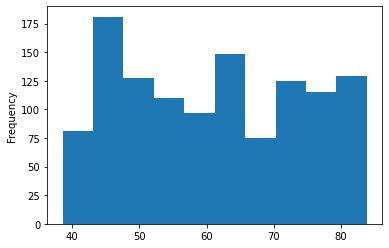

In [62]:
y.plot.hist()
plt.show()

<AxesSubplot:xlabel='avg_temp'>

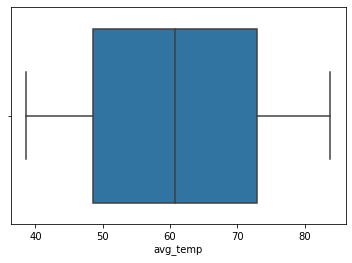

In [65]:
sns.boxplot(y)

In [64]:
y.describe()

count    1188.000000
mean       60.982808
std        12.981984
min        38.577200
25%        48.605450
50%        60.741500
75%        72.879350
max        83.825600
Name: avg_temp, dtype: float64

The mean and the median average temperatures are both 61 degrees, so there don't seem to be any outliers. The minimum average temp is 38 degrees, which is above freezing. The maximum average temperature is only 83 degrees, which is mild compared to an average maximum in San Antonio.

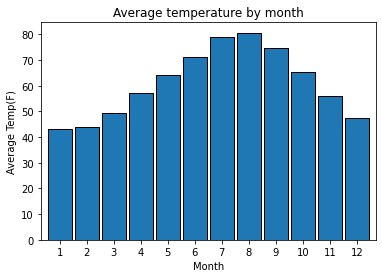

In [66]:
ax = y.groupby(y.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average temperature by month', xlabel='Month', ylabel='Average Temp(F)')
plt.show()

The hottest month is August and the coldest month is January.

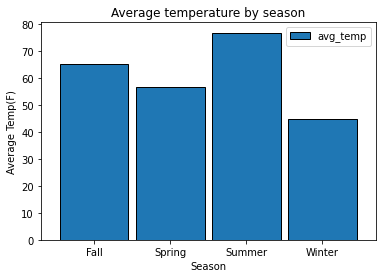

In [69]:
ax = train.groupby('season').mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average temperature by season', xlabel='Season', ylabel='Average Temp(F)')
plt.show()

The seasons follow the same trends as the months: summer-hottest, winter-coldest

## Visualize target over time

<AxesSubplot:title={'center':'Yearly average temperature for Sasebo'}, xlabel='dt'>

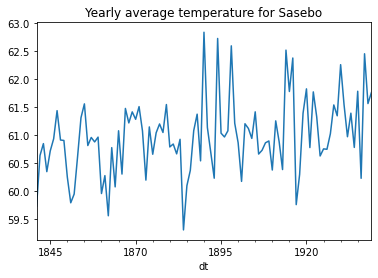

In [78]:
y.resample('A').mean().plot(title="Yearly average temperature for Sasebo")

<AxesSubplot:title={'center':'Average temperature in Sasebo by decade'}, xlabel='dt'>

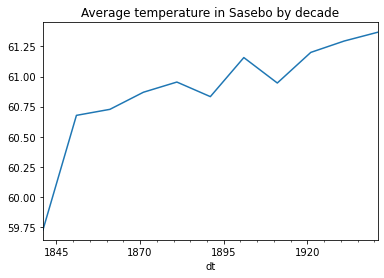

In [83]:
y.resample('10A').mean().plot(title="Average temperature in Sasebo by decade")

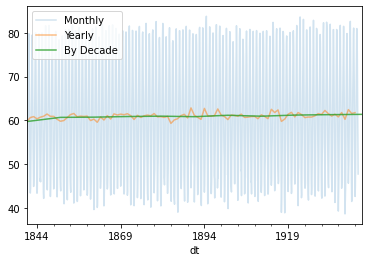

In [90]:
y.plot(alpha=.2, label='Monthly')
y.resample('A').mean().plot(alpha=.5, label='Yearly')
y.resample('10A').mean().plot(alpha=.8, label='By Decade')
plt.legend()

The temperature changes look drastic when only looking at month-to-month or year-to-year changes, but when overlaying decade, yearly, and monthly data, the changes in average temperature are very small.

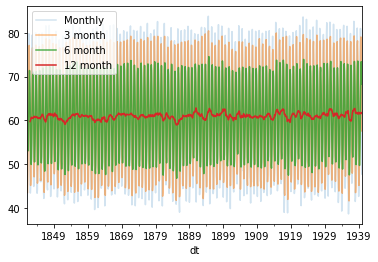

In [93]:
y.plot(alpha=.2, label='Monthly')
y.resample('M').mean().rolling(3).mean().plot(alpha=.5, label='3 month')
y.resample('M').mean().rolling(6).mean().plot(alpha=.8, label='6 month')
y.resample('M').mean().rolling(12).mean().plot(label='12 month')
plt.legend()

## Visualize change over time 

<AxesSubplot:title={'center':'Average year-to-year change in temp'}, xlabel='dt'>

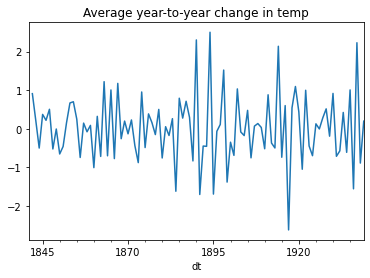

In [96]:
y.resample('A').mean().diff().plot(title='Average year-to-year change in temp')

<AxesSubplot:title={'center':'Average decade-to-decade change in temperature'}, xlabel='dt'>

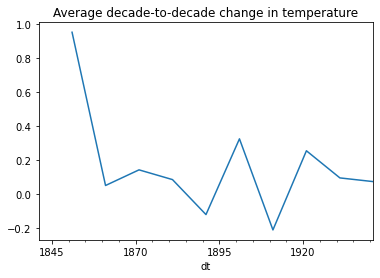

In [97]:
y.resample('10A').mean().diff().plot(title='Average decade-to-decade change in temperature')

## Seasonal Plot

<AxesSubplot:title={'center':'Seasonal Plot'}, xlabel='dt'>

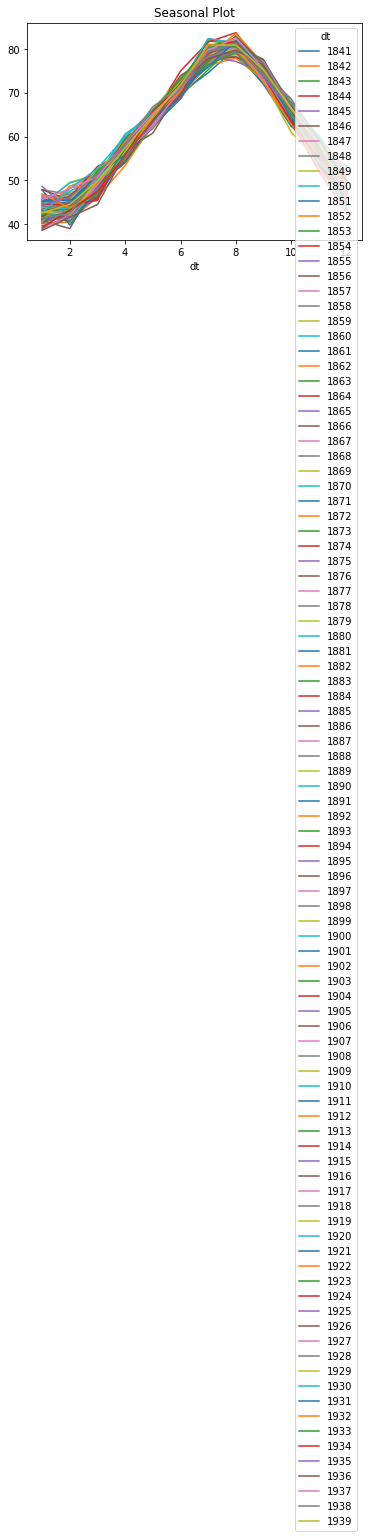

In [98]:
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot(title='Seasonal Plot')

The seaonsal plot for each year maintains the same shape overall with maybe a 5-10 degree difference in mimimum and maximum temperatures between years.

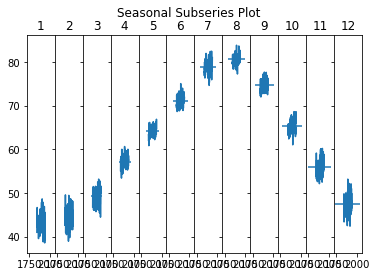

In [99]:
table = y.groupby([y.index.year, y.index.month]).mean().unstack()

fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month)
    ax.hlines(subset.mean(), *ax.get_xlim())
    ax.set(xlabel='')

fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
fig.subplots_adjust(wspace=0)

There is no clear trend in any of the months over the years.

## Lag plot

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

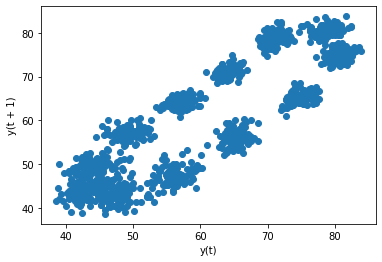

In [108]:
pd.plotting.lag_plot(train.avg_temp.resample('M').mean(), lag=1)

Positive correlation with previous month temperature

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 3)'>

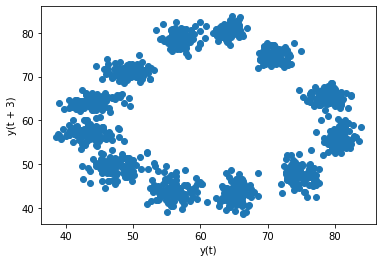

In [109]:
pd.plotting.lag_plot(train.avg_temp.resample('M').mean(), lag=3)

No apparent correlation with previous quarter average temp.

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 6)'>

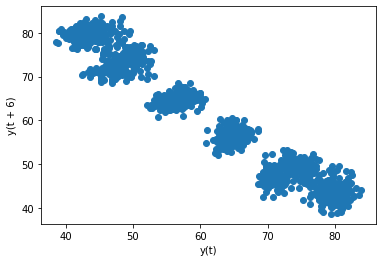

In [110]:
pd.plotting.lag_plot(train.avg_temp.resample('M').mean(), lag=6)

Negative correlation with 6 month lag temp.

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 12)'>

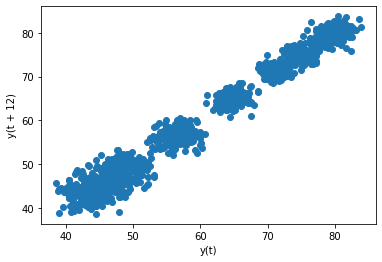

In [111]:
pd.plotting.lag_plot(train.avg_temp.resample('M').mean(), lag=12)

Positive correlation with 12 month lag temp.

## Autocorrelation

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

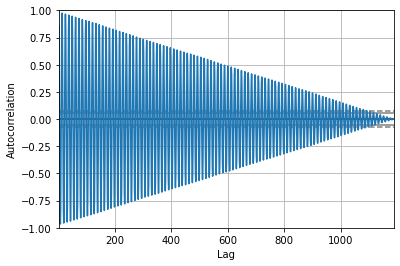

In [116]:
pd.plotting.autocorrelation_plot(train.avg_temp)

Significant month-to-month correlation. Seasonality very apparent.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

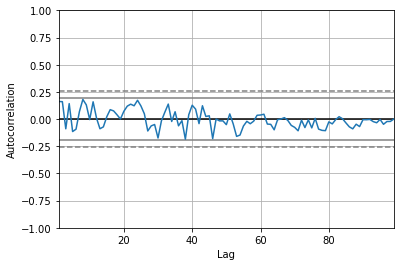

In [117]:
pd.plotting.autocorrelation_plot(train.avg_temp.resample('A').mean())

Insignificant correlation from year-to-year. No seasonality.

<AxesSubplot:xlabel='dt'>

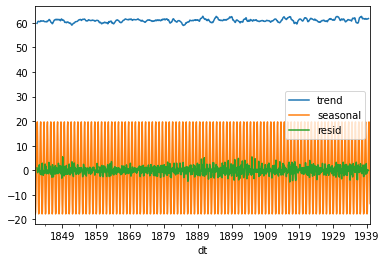

In [126]:
y = train.avg_temp

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})

decomposition.iloc[:, 1:].plot()

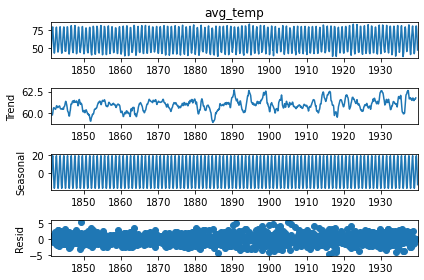

In [127]:
result.plot()
None

This also demonstrates high seasonality from month-to-month.

<AxesSubplot:xlabel='dt'>

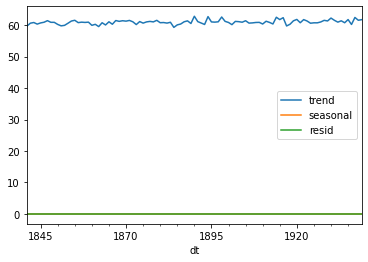

In [124]:
y = train.avg_temp.resample('A').mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})

decomposition.iloc[:, 1:].plot()

This shows no seasonality from year-to-year, but both month-to-month and year-to-year show a flat trend for average temp.

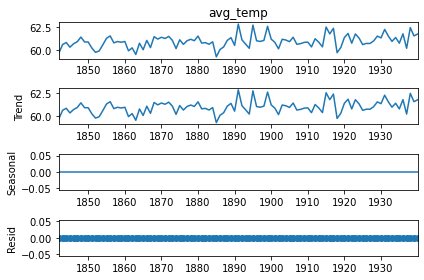

In [125]:
result.plot()
None

## Categories over time

In [161]:
yearly_seasons = train.groupby('season').resample('A').mean()

avg_temp
season dt                  
Fall   1841-12-31   64.1216
       1842-12-31   63.8150
       1843-12-31   64.2518
       1844-12-31   64.7954
       1845-12-31   63.0674
...                     ...
Winter 1935-12-31   45.4826
       1936-12-31   43.3712
       1937-12-31   46.7582
       1938-12-31   43.9928
       1939-12-31   44.9450

[396 rows x 1 columns]

In [166]:
fall = yearly_seasons.loc[['Fall']]
winter = yearly_seasons.loc[['Winter']]
spring = yearly_seasons.loc[['Spring']]
summer = yearly_seasons.loc[['Summer']]

<AxesSubplot:xlabel='season,dt'>

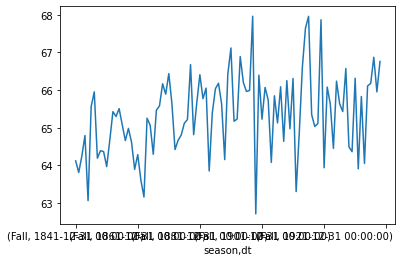

In [167]:
fall.avg_temp.plot()

<AxesSubplot:xlabel='season,dt'>

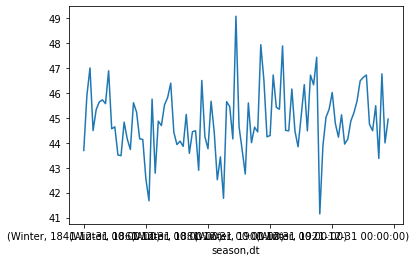

In [168]:
winter.avg_temp.plot()

<AxesSubplot:xlabel='season,dt'>

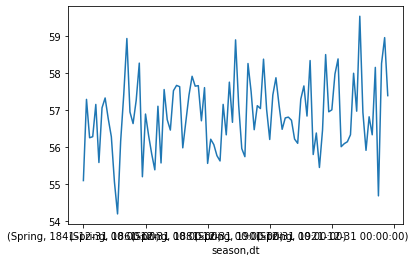

In [169]:
spring.avg_temp.plot()

<AxesSubplot:xlabel='season,dt'>

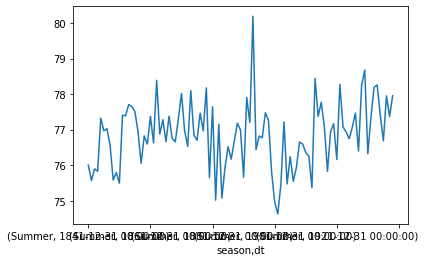

In [170]:
summer.avg_temp.plot()

I don't really see any trend in any of the seasons when comparing the avg temps for the year in that season.

## Modeling 

In [202]:
def _evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 4)
    return rmse

In [203]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = _evaluate(target_var)
    print(target_var, '-- RMSE: {:.4f}'.format(rmse))
    plt.show()

In [204]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [188]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

### Last observed value

In [189]:
# Find the last observed value from temp
last_temp = train.avg_temp[-1:][0]
last_temp

47.708600000000004

In [227]:
def make_predictions(predicted_temps, target):
    yhat_df = pd.DataFrame({target : [predicted_temps]}, 
                           index = validate.index)
    return yhat_df

In [200]:
# Apply the last temp as a prediction for the validate set
yhat_df = make_predictions(last_temp, 'avg_temp')

yhat_df.head()

,avg_temp
dt,
1940-01-01,47.7086
1940-02-01,47.7086
1940-03-01,47.7086
1940-04-01,47.7086
1940-05-01,47.7086


avg_temp -- RMSE: 19.2149


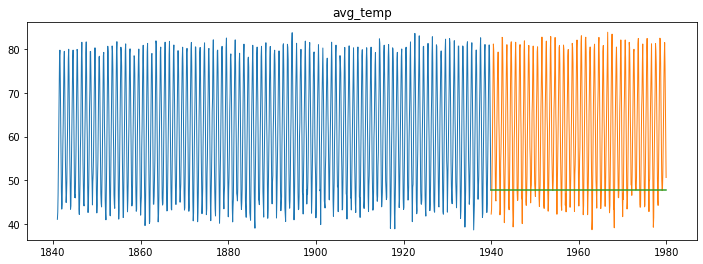

In [205]:
plot_and_eval('avg_temp')

In [206]:
eval_df = append_eval_df("last_observed_value", target_var='avg_temp')
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,19.2149


## Simple Average

In [207]:
simple_average = train.avg_temp.mean()
simple_average

60.98280757575756

In [209]:
yhat_df = make_predictions(simple_average, 'avg_temp')
yhat_df.head()

,avg_temp
dt,
1940-01-01,60.982808
1940-02-01,60.982808
1940-03-01,60.982808
1940-04-01,60.982808
1940-05-01,60.982808


avg_temp -- RMSE: 12.9417


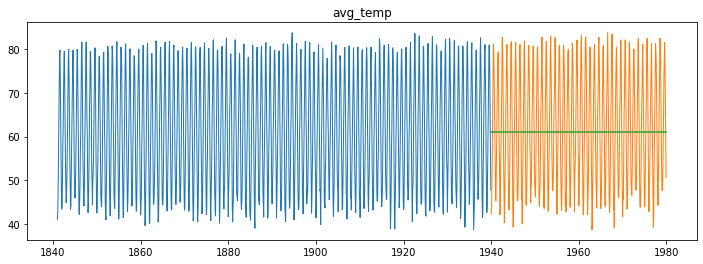

In [210]:
plot_and_eval('avg_temp')

In [213]:
eval_df = append_eval_df('simple_average', 'avg_temp')
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,19.2149
1,simple_average,avg_temp,12.9417
2,simple_average,avg_temp,12.9417


## Moving average

In [243]:
# FIXME!
def generate_rolling_avg_forecasts(train, targets, periods, eval_df):
    for target in targets:
        
        for period in periods: 
            predictions = train[target].rolling(period).mean()[-1]
            yhat_df = make_predictions(predictions, target)
            model_type = str(period) + 'd_moving_avg'
            print(f"before {eval_df}")
            eval_df = append_eval_df(model_type = model_type, target_var = target)
            print(f"after {eval_df}")
                       
    return eval_df

In [244]:
periods = [30, 90, 120, 150, 180]
eval_df = generate_rolling_avg_forecasts(train, ['avg_temp'], periods, eval_df)
eval_df

before             model_type target_var     rmse
0  last_observed_value   avg_temp  19.2149
1       simple_average   avg_temp  12.9417
2      180d_moving_avg   avg_temp  12.9479
after             model_type target_var     rmse
0  last_observed_value   avg_temp  19.2149
1       simple_average   avg_temp  12.9417
2      180d_moving_avg   avg_temp  12.9479
3       30d_moving_avg   avg_temp  12.9479
before             model_type target_var     rmse
0  last_observed_value   avg_temp  19.2149
1       simple_average   avg_temp  12.9417
2      180d_moving_avg   avg_temp  12.9479
3       30d_moving_avg   avg_temp  12.9479
after             model_type target_var     rmse
0  last_observed_value   avg_temp  19.2149
1       simple_average   avg_temp  12.9417
2      180d_moving_avg   avg_temp  12.9479
3       90d_moving_avg   avg_temp  12.9479
before             model_type target_var     rmse
0  last_observed_value   avg_temp  19.2149
1       simple_average   avg_temp  12.9417
2      180d_moving_av

,model_type,target_var,rmse
0,last_observed_value,avg_temp,19.2149
1,simple_average,avg_temp,12.9417
2,180d_moving_avg,avg_temp,12.9479
3,180d_moving_avg,avg_temp,12.9479


In [267]:
rolling_avg = train.avg_temp.rolling(180).mean()[-1]
rolling_avg

61.34461

In [268]:
yhat_df = make_predictions(rolling_avg, 'avg_temp')
yhat_df.head()

,avg_temp
dt,
1940-01-01,61.34461
1940-02-01,61.34461
1940-03-01,61.34461
1940-04-01,61.34461
1940-05-01,61.34461


avg_temp -- RMSE: 12.9198


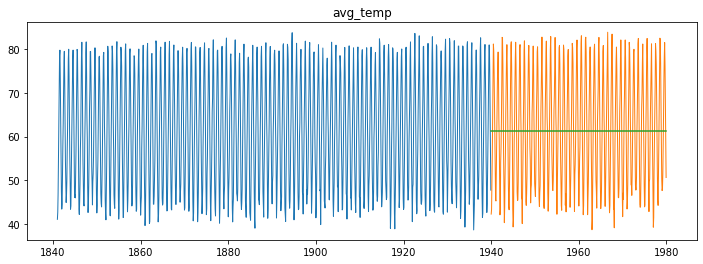

In [269]:
plot_and_eval('avg_temp')

In [270]:
eval_df = append_eval_df('180d_rolling_average', 'avg_temp')
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,19.2149
1,simple_average,avg_temp,12.9417
2,30d_rolling_average,avg_temp,12.9479
3,90d_rolling_average,avg_temp,12.9067
4,120d_rolling_average,avg_temp,12.9144
5,150d_rolling_average,avg_temp,12.9078
6,180d_rolling_average,avg_temp,12.9198


## Holt's Linear Trend

avg_temp 



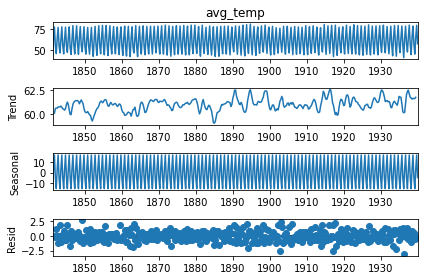

In [276]:
print('avg_temp', '\n')
sm.tsa.seasonal_decompose(train['avg_temp'].resample('Q').mean()).plot()
plt.show()

In [281]:
model = Holt(train.avg_temp, exponential=False, damped=True)
model = model.fit(optimized=True)
predictions = model.predict(start = validate.index[0], end = validate.index[-1])
yhat_df['avg_temp'] = predictions
yhat_df

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


,avg_temp
dt,
1940-01-01,39.144634
1940-02-01,32.293183
1940-03-01,26.811804
1940-04-01,22.426525
1940-05-01,18.918163
...,...
1979-08-01,4.881916
1979-09-01,4.881916
1979-10-01,4.881916


avg_temp -- RMSE: 58.2536


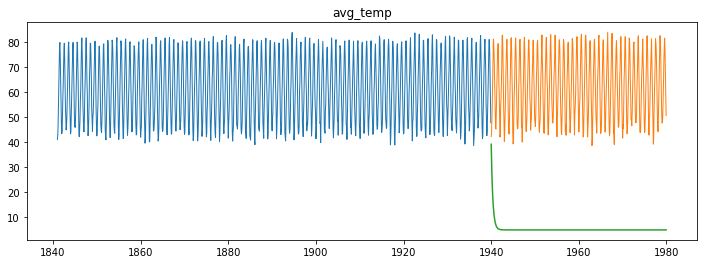

In [282]:
plot_and_eval('avg_temp')

In [283]:
eval_df = append_eval_df('optimized_holt', 'avg_temp')
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,19.2149
1,simple_average,avg_temp,12.9417
2,30d_rolling_average,avg_temp,12.9479
3,90d_rolling_average,avg_temp,12.9067
4,120d_rolling_average,avg_temp,12.9144
5,150d_rolling_average,avg_temp,12.9078
6,180d_rolling_average,avg_temp,12.9198
7,optimized_holt,avg_temp,58.2536


In [284]:
model = Holt(train.avg_temp, exponential=False)
model = model.fit(smoothing_level=.1, smoothing_slope=.1, optimized=False)
predictions = model.predict(start = validate.index[0], end = validate.index[-1])
yhat_df['avg_temp'] = predictions
yhat_df

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


,avg_temp
dt,
1940-01-01,63.747765
1940-02-01,63.866856
1940-03-01,63.985947
1940-04-01,64.105038
1940-05-01,64.224128
...,...
1979-08-01,120.315910
1979-09-01,120.435000
1979-10-01,120.554091


avg_temp -- RMSE: 36.7364


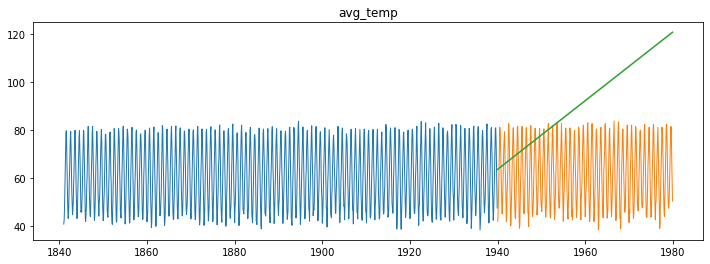

In [285]:
plot_and_eval('avg_temp')

In [286]:
eval_df = append_eval_df('customized_holt', 'avg_temp')

In [287]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,19.2149
1,simple_average,avg_temp,12.9417
2,30d_rolling_average,avg_temp,12.9479
3,90d_rolling_average,avg_temp,12.9067
4,120d_rolling_average,avg_temp,12.9144
5,150d_rolling_average,avg_temp,12.9078
6,180d_rolling_average,avg_temp,12.9198
7,optimized_holt,avg_temp,58.2536
8,customized_holt,avg_temp,36.7364


## Predict based on previous cycle

In [288]:
train.tail()

,avg_temp,day_of_week,month,season,temp_levels
dt,,,,,
1939-08-01,81.0068,Tuesday,August,Summer,high_temp
1939-09-01,75.2792,Friday,September,Fall,high_temp
1939-10-01,66.5870,Sunday,October,Fall,above_average_temp
1939-11-01,58.4132,Wednesday,November,Fall,below_average_temp
1939-12-01,47.7086,Friday,December,Winter,low_temp


In [305]:
validate = validate['1940']

In [303]:
yhat_df = train['1939'].avg_temp + train.avg_temp.diff(365).mean()
yhat_df

dt
1939-01-01    42.902016
1939-02-01    44.867616
1939-03-01    50.249616
1939-04-01    57.795216
1939-05-01    65.079816
1939-06-01    72.200616
1939-07-01    81.306816
1939-08-01    81.328416
1939-09-01    75.600816
1939-10-01    66.908616
1939-11-01    58.734816
1939-12-01    48.030216
Name: avg_temp, dtype: float64

In [306]:
yhat_df.index = validate.index

In [309]:
yhat_df = pd.DataFrame(yhat_df, columns=['avg_temp'])

avg_temp -- RMSE: 1.1452


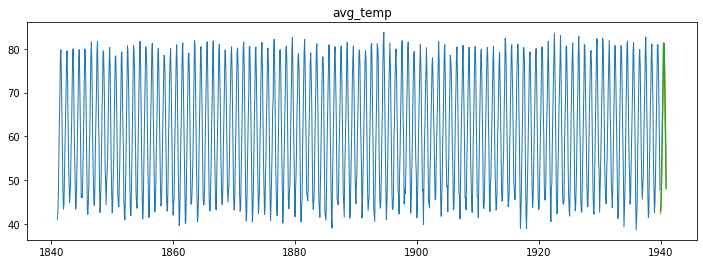

In [310]:
plot_and_eval('avg_temp')

In [311]:
eval_df = append_eval_df('previous_cycle', 'avg_temp')

In [312]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,19.2149
1,simple_average,avg_temp,12.9417
2,30d_rolling_average,avg_temp,12.9479
3,90d_rolling_average,avg_temp,12.9067
4,120d_rolling_average,avg_temp,12.9144
5,150d_rolling_average,avg_temp,12.9078
6,180d_rolling_average,avg_temp,12.9198
7,optimized_holt,avg_temp,58.2536
8,customized_holt,avg_temp,36.7364
9,previous_cycle,avg_temp,1.1452


In [313]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
9,previous_cycle,avg_temp,1.1452
3,90d_rolling_average,avg_temp,12.9067
5,150d_rolling_average,avg_temp,12.9078
4,120d_rolling_average,avg_temp,12.9144
6,180d_rolling_average,avg_temp,12.9198
1,simple_average,avg_temp,12.9417
2,30d_rolling_average,avg_temp,12.9479
0,last_observed_value,avg_temp,19.2149
8,customized_holt,avg_temp,36.7364
7,optimized_holt,avg_temp,58.2536


## Evaluate with previous cycle model

In [316]:
test = test['2012']
yhat_df = validate.avg_temp + train.avg_temp.diff(365).mean()
yhat_df.index = test.index
yhat_df

dt
2012-01-01    42.529416
2012-02-01    43.607616
2012-03-01    49.293816
2012-04-01    56.110416
2012-05-01    65.038416
2012-06-01    72.247416
2012-07-01    81.557016
2012-08-01    79.962216
2012-09-01    74.832216
2012-10-01    67.320816
2012-11-01    58.994016
2012-12-01    50.035416
Name: avg_temp, dtype: float64

In [317]:
yhat_df = pd.DataFrame(yhat_df, columns=['avg_temp'])

avg_temp -- RMSE: 0.3216


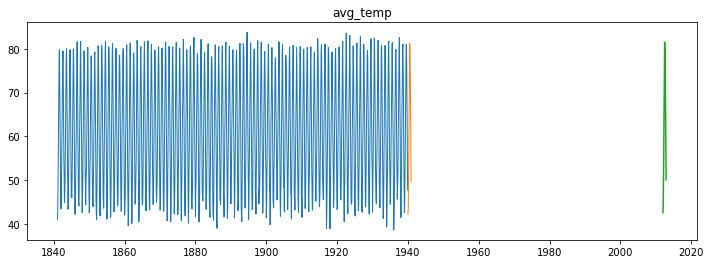

In [318]:
plot_and_eval('avg_temp')

In [320]:
# Need to adjust my splits. I understand how to do it now.